# `Setup`

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### `Config`

In [2]:
MODEL_NAME = 'TinyVGG_best'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [3]:
img_size_L = (168, 224)
# img_size_S = (93, 124)

# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(img_size_L, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize(img_size_L, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [4]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val+test'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 15646
Lenght of val data: 3345
Lenght of val data: 3433


#### `Model`

In [13]:
# TinyVGG inpsired
# First Convolution Blocks With BatchNorm, MaxPool and Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channesl, out_channls, kernel_size = (3, 3), stride=1, pool_kernel = (2,2), dropout_rate = .2):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channesl,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.Conv2d(in_channels=out_channls,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.MaxPool2d(kernel_size = pool_kernel),
            nn.Dropout(dropout_rate))
    
    def forward(self, x):
        return self.main(x)

# Added couple extra fully connected layers
class FullyConnected(nn.Module):
    def __init__(self, in_features, out_featuers, dropout_rate) -> None:
        super(FullyConnected, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_featuers),
            nn.ReLU(True),
            nn.BatchNorm1d(out_featuers),
            nn.Dropout(dropout_rate),)
    
    def forward(self, x):
        return self.main(x)
    
    
class TinyVGGish(torch.nn.Module):
    def __init__(self, 
                 filters = 32, 
                 num_classes = 10,
                 kernel_size = 3, 
                 stride = 1, 
                 in_channels = 3,
                 pool_kernel_size = 2):
        
        """TinyVGG Inspired Model with Added complexity and Regularizaiton"""
        super(TinyVGGish, self).__init__()
        
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.25),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            ConvBlock(in_channesl=filters*2, out_channls=filters*4, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.5),
            nn.Flatten(),
            FullyConnected(in_features=52224, out_featuers=10, dropout_rate=.3),
            # FullyConnected(in_features=512, out_featuers=128, dropout_rate=dense_dropout_rate),
            # FullyConnected(in_features=128, out_featuers=num_classes, dropout_rate=dense_dropout_rate),
            )

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

In [14]:
# Initialize Efficientnet model
model = TinyVGGish(num_classes = 10)

In [15]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [16]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGish                               [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─ConvBlock: 2-1                    [32, 32, 82, 110]         --
│    │    └─Sequential: 3-1              [32, 32, 82, 110]         10,272
│    └─ConvBlock: 2-2                    [32, 64, 39, 53]          --
│    │    └─Sequential: 3-2              [32, 64, 39, 53]          55,680
│    └─ConvBlock: 2-3                    [32, 128, 17, 24]         --
│    │    └─Sequential: 3-3              [32, 128, 17, 24]         221,952
│    └─Flatten: 2-4                      [32, 52224]               --
│    └─FullyConnected: 2-5               [32, 10]                  --
│    │    └─Sequential: 3-4              [32, 10]                  522,270
Total params: 810,174
Trainable params: 810,174
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 39.19
Input size (MB): 14.45
F

#### `Training Methods`

In [17]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [18]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [19]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [20]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [21]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [27]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

In [29]:
# Setting seed and general training setup
torch.manual_seed(seed)
epcohs = 50
learming_rate = 0.01
momentum = .9
weight_decay = 1e-5
nestrov = True
MODEL_NAME = 'TinyVGG'

# Creating Model Object
model = TinyVGGish(num_classes = 10).to(device)

# Optimizer and and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nestrov)
# optimizer = torch.optim.Adam(model.parameters(), lr=learming_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max = epochs,  
                                                       eta_min = 0,
                                                       verbose=1)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopping = EarlyStopper(patience=7, min_delta=.03)

Adjusting learning rate of group 0 to 1.0000e-02.



Epoch 1 of 50 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2.46: adjusting learning rate of group 0 to 9.9406e-03.
Epoch 1 of 50 (4:59) - Train loss: 2.33401 - Train acc: 0.14169 - Val loss: 2.45547 - Val acc: 0.11183
Saving model with new best val_loss: 2.45547

Epoch 2 of 50 started...
Epoch 2.43: adjusting learning rate of group 0 to 9.9416e-03.
Epoch 2 of 50 (4:54) - Train loss: 2.08162 - Train acc: 0.25808 - Val loss: 2.43438 - Val acc: 0.20439
Saving model with new best val_loss: 2.43438

Epoch 3 of 50 started...
Epoch 2.30: adjusting learning rate of group 0 to 9.9481e-03.
Epoch 3 of 50 (4:50) - Train loss: 1.72538 - Train acc: 0.40850 - Val loss: 2.29590 - Val acc: 0.29116
Saving model with new best val_loss: 2.29590

Epoch 4 of 50 started...
Epoch 2.37: adjusting learning rate of group 0 to 9.9445e-03.
Epoch 4 of 50 (4:37) - Train loss: 1.50877 - Train acc: 0.48338 - Val loss: 2.37427 - Val acc: 0.32542
Early Stopping Counter 1 of 7

Epoch 5 of 50 started...
Epoch 2.55: adjusting learning rate of group 0 to 9.9362e-03.
Epoch 5 o

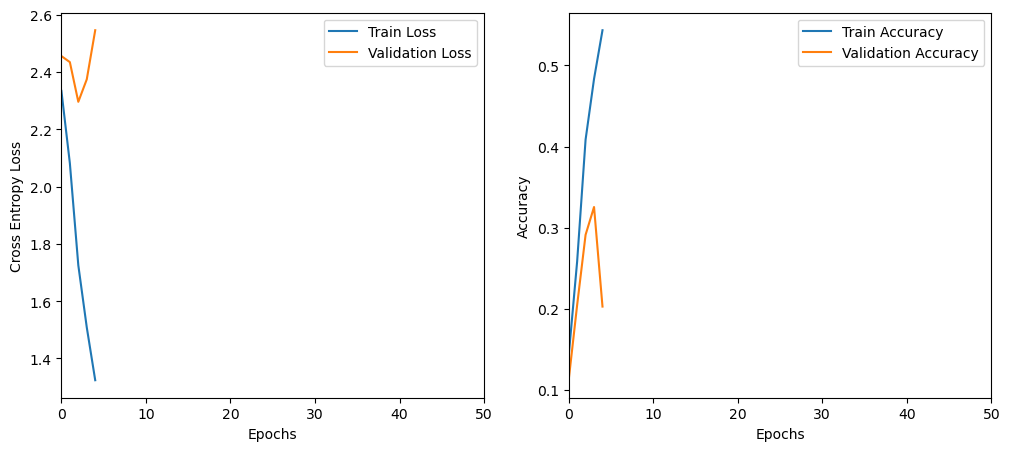

Early Stopping Counter 2 of 7

Epoch 6 of 50 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2.18: adjusting learning rate of group 0 to 9.9530e-03.
Epoch 6 of 50 (4:43) - Train loss: 1.22085 - Train acc: 0.57396 - Val loss: 2.18326 - Val acc: 0.32230
Saving model with new best val_loss: 2.18326
Early Stopping Counter Reset

Epoch 7 of 50 started...
Epoch 2.51: adjusting learning rate of group 0 to 9.9382e-03.
Epoch 7 of 50 (4:48) - Train loss: 1.15559 - Train acc: 0.58585 - Val loss: 2.50582 - Val acc: 0.31021
Early Stopping Counter 1 of 7

Epoch 8 of 50 started...
Epoch 1.97: adjusting learning rate of group 0 to 9.9616e-03.
Epoch 8 of 50 (4:36) - Train loss: 1.09746 - Train acc: 0.60315 - Val loss: 1.97368 - Val acc: 0.32906
Saving model with new best val_loss: 1.97368
Early Stopping Counter Reset

Epoch 9 of 50 started...
Epoch 2.35: adjusting learning rate of group 0 to 9.9454e-03.
Epoch 9 of 50 (4:34) - Train loss: 1.06334 - Train acc: 0.61231 - Val loss: 2.35474 - Val acc: 0.31768
Early Stopping Counter 1 of 7

Epoch 10 of 50 started...
Epoch 2.09: adjusting learn

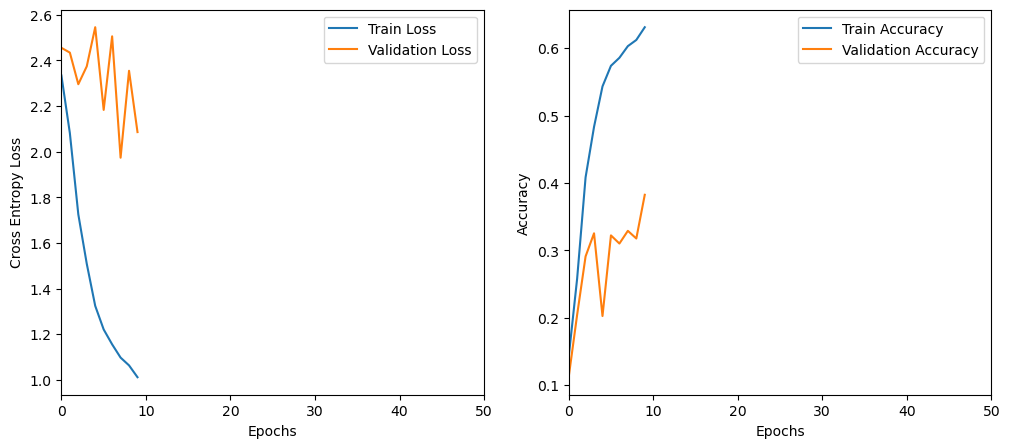

Early Stopping Counter 2 of 7

Epoch 11 of 50 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.82: adjusting learning rate of group 0 to 9.9674e-03.
Epoch 11 of 50 (4:54) - Train loss: 0.99256 - Train acc: 0.62975 - Val loss: 1.81800 - Val acc: 0.45243
Saving model with new best val_loss: 1.81800
Early Stopping Counter Reset

Epoch 12 of 50 started...
Epoch 1.76: adjusting learning rate of group 0 to 9.9693e-03.
Epoch 12 of 50 (4:36) - Train loss: 0.95737 - Train acc: 0.64042 - Val loss: 1.76380 - Val acc: 0.47502
Saving model with new best val_loss: 1.76380

Epoch 13 of 50 started...
Epoch 1.98: adjusting learning rate of group 0 to 9.9615e-03.
Epoch 13 of 50 (4:35) - Train loss: 0.93390 - Train acc: 0.64266 - Val loss: 1.97761 - Val acc: 0.45504
Early Stopping Counter 1 of 7

Epoch 14 of 50 started...
Epoch 2.17: adjusting learning rate of group 0 to 9.9536e-03.
Epoch 14 of 50 (4:35) - Train loss: 0.90658 - Train acc: 0.65582 - Val loss: 2.16959 - Val acc: 0.44336
Early Stopping Counter 2 of 7

Epoch 15 of 50 started...
Epoch 1.72: adjusting learning rate of group 0 to

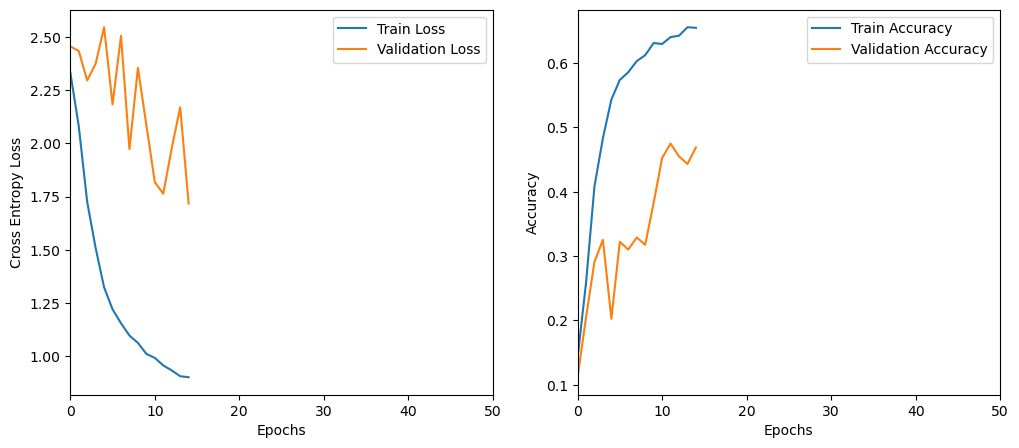

Early Stopping Counter Reset

Epoch 16 of 50 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.91: adjusting learning rate of group 0 to 9.9639e-03.
Epoch 16 of 50 (4:36) - Train loss: 0.88952 - Train acc: 0.65742 - Val loss: 1.91295 - Val acc: 0.44347
Early Stopping Counter 1 of 7

Epoch 17 of 50 started...


KeyboardInterrupt: 

In [32]:
# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping,
                model_name=MODEL_NAME)

### Testing on Test Images

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [ ]:
# Best model
best_model = MnasNet(10) 
best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/MnasNet/MnasNet_20231201_083505_best.pt'))
best_model.to(device)

best_acc, best_lab, best_pred = test_loop(best_model, val_dataloader, device)

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for i, data in enumerate(test_dataloader):
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Forward pass
    prediction = model(imgs)
    
    break

In [ ]:
prediction.argmax(1)[0].item()

In [ ]:
index = 16
print('Prediction:', config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())])
print('True:', config['dataset']['class_mapping']['c' + str(labels[index].item())])

plt.imshow(imgs[index].cpu().permute(1, 2, 0))